In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
from argparse import ArgumentParser
from double_net.double_net import DoubleNet, train_loop, train_loop_no_lagrange, test_loop, test_loop_random_start
from double_net import datasets as ds
import time
import double_net.plot_utils as pu
import importlib
import matplotlib.pyplot as plt
from double_net import utils_misreport as utils


In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [3]:
device

'cuda'

In [4]:
parser = ArgumentParser()
parser.add_argument('--random-seed', type=int, default=0)
parser.add_argument('--num-examples', type=int, default=131072 * 4)
parser.add_argument('--test-num-examples', type=int, default=10000)
parser.add_argument('--test-iter', type=int, default=5)
parser.add_argument('--n-agents', type=int, default=1)
parser.add_argument('--n-items', type=int, default=2)
parser.add_argument('--num-epochs', type=int, default=100)
parser.add_argument('--batch-size', type=int, default=128 * 32)
parser.add_argument('--test-batch-size', type=int, default=10000)
parser.add_argument('--model-lr', type=float, default=1e-3)
parser.add_argument('--misreport-lr', type=float, default=1e-1)
parser.add_argument('--misreport-iter', type=int, default=25)
parser.add_argument('--test-misreport-iter', type=int, default=2000)
parser.add_argument('--rho', type=float, default=1.0)
parser.add_argument('--rho-incr-iter', type=int, default=2)
parser.add_argument('--rho-incr-amount', type=float, default=1.0)
parser.add_argument('--lagr-update-iter', type=int, default=100)
parser.add_argument('--rgt-start', type=int, default=0)
parser.add_argument('--sinkhorn-epsilon', type=float, default=5e-2)
parser.add_argument('--sinkhorn-rounds', type=int, default=20)

dataset_name = ""
args = parser.parse_args(args=[])
args

Namespace(batch_size=4096, lagr_update_iter=100, misreport_iter=25, misreport_lr=0.1, model_lr=0.001, n_agents=1, n_items=2, num_epochs=100, num_examples=524288, random_seed=0, rgt_start=0, rho=1.0, rho_incr_amount=1.0, rho_incr_iter=2, sinkhorn_epsilon=0.05, sinkhorn_rounds=20, test_batch_size=10000, test_iter=5, test_misreport_iter=2000, test_num_examples=10000)

In [5]:
torch.manual_seed(args.random_seed)
np.random.seed(args.random_seed)

item_ranges = ds.preset_valuation_range(args.n_agents, args.n_items, dataset_name)
clamp_op = ds.get_clamp_op(item_ranges)

model = DoubleNet(
    args.n_agents, args.n_items, item_ranges, args.sinkhorn_epsilon, args.sinkhorn_rounds, marginal_choice='exact_one'
).to(device)

train_data = ds.generate_dataset_nxk(args.n_agents, args.n_items, args.num_examples, item_ranges).to(device)
train_loader = ds.Dataloader(train_data, batch_size=args.batch_size, shuffle=True)

In [6]:
%%time
mean_rgt, mean_pay, lagr_mults = train_loop(model, train_loader, args, device=device)

  1%|          | 1/100 [01:04<1:45:59, 64.23s/it]

{'regret_max': 0.5448421835899353, 'regret_mean': 0.014919913373887539, 'regret_mults': tensor([[5.6158]], device='cuda:0'), 'payment': 0.05350997671484947}


  2%|▏         | 2/100 [02:08<1:44:52, 64.21s/it]

{'regret_max': 0.07554197311401367, 'regret_mean': 0.007496367208659649, 'regret_mults': tensor([[6.4041]], device='cuda:0'), 'payment': 0.06838853657245636}


  3%|▎         | 3/100 [03:12<1:43:46, 64.19s/it]

{'regret_max': 0.06872594356536865, 'regret_mean': 0.004851548932492733, 'regret_mults': tensor([[7.2028]], device='cuda:0'), 'payment': 0.06889524310827255}


  4%|▍         | 4/100 [04:14<1:41:44, 63.58s/it]

{'regret_max': 0.06494474411010742, 'regret_mean': 0.0036932299844920635, 'regret_mults': tensor([[8.7511]], device='cuda:0'), 'payment': 0.06306339800357819}


  5%|▌         | 5/100 [05:16<1:40:01, 63.17s/it]

{'regret_max': 0.06577491760253906, 'regret_mean': 0.003009591018781066, 'regret_mults': tensor([[9.7562]], device='cuda:0'), 'payment': 0.05929793417453766}


  6%|▌         | 6/100 [06:18<1:38:25, 62.82s/it]

{'regret_max': 0.06769436597824097, 'regret_mean': 0.0025565610267221928, 'regret_mults': tensor([[10.6038]], device='cuda:0'), 'payment': 0.05666133016347885}


  7%|▋         | 7/100 [07:21<1:37:02, 62.60s/it]

{'regret_max': 0.06303799152374268, 'regret_mean': 0.002321844920516014, 'regret_mults': tensor([[11.7176]], device='cuda:0'), 'payment': 0.05597596615552902}


  8%|▊         | 8/100 [08:23<1:36:03, 62.64s/it]

{'regret_max': 0.06947982311248779, 'regret_mean': 0.0021016979590058327, 'regret_mults': tensor([[14.0976]], device='cuda:0'), 'payment': 0.05408033728599548}


  9%|▉         | 9/100 [09:27<1:35:42, 63.10s/it]

{'regret_max': 0.05981945991516113, 'regret_mean': 0.0018566519720479846, 'regret_mults': tensor([[15.2707]], device='cuda:0'), 'payment': 0.05167841538786888}


 10%|█         | 10/100 [10:32<1:35:07, 63.41s/it]

{'regret_max': 0.06334161758422852, 'regret_mean': 0.001658886787481606, 'regret_mults': tensor([[16.6801]], device='cuda:0'), 'payment': 0.0492020808160305}


 11%|█         | 11/100 [11:36<1:34:25, 63.66s/it]

{'regret_max': 0.04988443851470947, 'regret_mean': 0.0017270066309720278, 'regret_mults': tensor([[19.1371]], device='cuda:0'), 'payment': 0.046969182789325714}


 12%|█▏        | 12/100 [12:40<1:33:36, 63.83s/it]

{'regret_max': 0.07934198528528214, 'regret_mean': 0.0018477715784683824, 'regret_mults': tensor([[20.2735]], device='cuda:0'), 'payment': 0.04661525785923004}


 13%|█▎        | 13/100 [13:44<1:32:49, 64.02s/it]

{'regret_max': 0.06959033012390137, 'regret_mean': 0.0014831733424216509, 'regret_mults': tensor([[21.4429]], device='cuda:0'), 'payment': 0.050614211708307266}


 14%|█▍        | 14/100 [14:49<1:31:50, 64.08s/it]

{'regret_max': 0.06317359954118729, 'regret_mean': 0.0015585469081997871, 'regret_mults': tensor([[22.7260]], device='cuda:0'), 'payment': 0.049711380153894424}


 15%|█▌        | 15/100 [15:53<1:30:50, 64.13s/it]

{'regret_max': 0.032569825649261475, 'regret_mean': 0.0011536688543856144, 'regret_mults': tensor([[25.1927]], device='cuda:0'), 'payment': 0.06229637563228607}


 16%|█▌        | 16/100 [16:57<1:29:50, 64.17s/it]

{'regret_max': 0.028680384159088135, 'regret_mean': 0.0010317449923604727, 'regret_mults': tensor([[26.5538]], device='cuda:0'), 'payment': 0.07111547887325287}


 17%|█▋        | 17/100 [18:01<1:28:46, 64.18s/it]

{'regret_max': 0.03239327669143677, 'regret_mean': 0.0010338773718103766, 'regret_mults': tensor([[27.5428]], device='cuda:0'), 'payment': 0.07373440265655518}


 18%|█▊        | 18/100 [19:06<1:27:42, 64.17s/it]

{'regret_max': 0.022810399532318115, 'regret_mean': 0.0006885561742819846, 'regret_mults': tensor([[28.8953]], device='cuda:0'), 'payment': 0.07362082600593567}


 19%|█▉        | 19/100 [20:10<1:26:38, 64.18s/it]

{'regret_max': 0.04566701501607895, 'regret_mean': 0.0008238428272306919, 'regret_mults': tensor([[29.3073]], device='cuda:0'), 'payment': 0.0719233974814415}


 20%|██        | 20/100 [21:14<1:25:37, 64.21s/it]

{'regret_max': 0.01254349946975708, 'regret_mean': 0.0004638347600121051, 'regret_mults': tensor([[29.8363]], device='cuda:0'), 'payment': 0.07501288503408432}


 21%|██        | 21/100 [22:18<1:24:30, 64.19s/it]

{'regret_max': 0.022574707865715027, 'regret_mean': 0.0004693996743299067, 'regret_mults': tensor([[30.2310]], device='cuda:0'), 'payment': 0.0742216408252716}


 22%|██▏       | 22/100 [23:22<1:23:27, 64.20s/it]

{'regret_max': 0.03442365676164627, 'regret_mean': 0.000621240702457726, 'regret_mults': tensor([[33.5474]], device='cuda:0'), 'payment': 0.07217845320701599}


 23%|██▎       | 23/100 [24:27<1:22:22, 64.19s/it]

{'regret_max': 0.012443289160728455, 'regret_mean': 0.00032866408582776785, 'regret_mults': tensor([[34.0947]], device='cuda:0'), 'payment': 0.07439667731523514}


 24%|██▍       | 24/100 [25:31<1:21:18, 64.20s/it]

{'regret_max': 0.009102821350097656, 'regret_mean': 0.0002678101882338524, 'regret_mults': tensor([[34.3562]], device='cuda:0'), 'payment': 0.07483957707881927}


 25%|██▌       | 25/100 [26:35<1:20:08, 64.12s/it]

{'regret_max': 0.008633121848106384, 'regret_mean': 0.00028030620887875557, 'regret_mults': tensor([[35.1843]], device='cuda:0'), 'payment': 0.07518038153648376}


 26%|██▌       | 26/100 [27:38<1:18:52, 63.95s/it]

{'regret_max': 0.030331134796142578, 'regret_mean': 0.0004594448546413332, 'regret_mults': tensor([[35.7245]], device='cuda:0'), 'payment': 0.07415200769901276}


 27%|██▋       | 27/100 [28:42<1:17:36, 63.79s/it]

{'regret_max': 0.008730962872505188, 'regret_mean': 0.00027496047550812364, 'regret_mults': tensor([[36.0104]], device='cuda:0'), 'payment': 0.07578229904174805}


 28%|██▊       | 28/100 [29:45<1:16:27, 63.71s/it]

{'regret_max': 0.012623876333236694, 'regret_mean': 0.00028534859302453697, 'regret_mults': tensor([[36.9362]], device='cuda:0'), 'payment': 0.07565270364284515}


 29%|██▉       | 29/100 [30:49<1:15:16, 63.62s/it]

{'regret_max': 0.010169029235839844, 'regret_mean': 0.0002472799096722156, 'regret_mults': tensor([[37.7988]], device='cuda:0'), 'payment': 0.07581323385238647}


 30%|███       | 30/100 [31:52<1:14:10, 63.58s/it]

{'regret_max': 0.01072704792022705, 'regret_mean': 0.00024266846594400704, 'regret_mults': tensor([[38.1782]], device='cuda:0'), 'payment': 0.0758093073964119}


 31%|███       | 31/100 [32:56<1:13:06, 63.57s/it]

{'regret_max': 0.01124235987663269, 'regret_mean': 0.00022241135593503714, 'regret_mults': tensor([[38.9180]], device='cuda:0'), 'payment': 0.07601740211248398}


 32%|███▏      | 32/100 [33:59<1:11:57, 63.50s/it]

{'regret_max': 0.03765365481376648, 'regret_mean': 0.0004259126144461334, 'regret_mults': tensor([[39.3327]], device='cuda:0'), 'payment': 0.07371150702238083}


 33%|███▎      | 33/100 [35:02<1:10:51, 63.46s/it]

{'regret_max': 0.010889321565628052, 'regret_mean': 0.00019422535842750221, 'regret_mults': tensor([[40.3001]], device='cuda:0'), 'payment': 0.0763869434595108}


 34%|███▍      | 34/100 [36:06<1:09:43, 63.39s/it]

{'regret_max': 0.013681530952453613, 'regret_mean': 0.00021402639686129987, 'regret_mults': tensor([[40.8911]], device='cuda:0'), 'payment': 0.07576403021812439}


 35%|███▌      | 35/100 [37:08<1:08:19, 63.07s/it]

{'regret_max': 0.010197758674621582, 'regret_mean': 0.0001811218389775604, 'regret_mults': tensor([[41.1904]], device='cuda:0'), 'payment': 0.07639491558074951}


 36%|███▌      | 36/100 [38:09<1:06:44, 62.58s/it]

{'regret_max': 0.01023167371749878, 'regret_mean': 0.00017564394511282444, 'regret_mults': tensor([[41.9622]], device='cuda:0'), 'payment': 0.07649485021829605}


 37%|███▋      | 37/100 [39:12<1:05:44, 62.62s/it]

{'regret_max': 0.010569363832473755, 'regret_mean': 0.00016851825057528913, 'regret_mults': tensor([[42.2986]], device='cuda:0'), 'payment': 0.07673780620098114}


 38%|███▊      | 38/100 [40:15<1:04:54, 62.81s/it]

{'regret_max': 0.01153707504272461, 'regret_mean': 0.00017251679673790932, 'regret_mults': tensor([[42.4988]], device='cuda:0'), 'payment': 0.07636014372110367}


 39%|███▉      | 39/100 [41:19<1:04:01, 62.98s/it]

{'regret_max': 0.012222900986671448, 'regret_mean': 0.00020370860875118524, 'regret_mults': tensor([[42.9720]], device='cuda:0'), 'payment': 0.07538701593875885}


 40%|████      | 40/100 [42:21<1:02:42, 62.71s/it]

{'regret_max': 0.009954184293746948, 'regret_mean': 0.00016213682829402387, 'regret_mults': tensor([[43.5385]], device='cuda:0'), 'payment': 0.07650741934776306}


 41%|████      | 41/100 [43:24<1:01:51, 62.91s/it]

{'regret_max': 0.011876702308654785, 'regret_mean': 0.00015374275972135365, 'regret_mults': tensor([[43.8672]], device='cuda:0'), 'payment': 0.0765940248966217}


 42%|████▏     | 42/100 [44:27<1:00:54, 63.00s/it]

{'regret_max': 0.010365098714828491, 'regret_mean': 0.00014504232967738062, 'regret_mults': tensor([[44.1013]], device='cuda:0'), 'payment': 0.07671006768941879}


 43%|████▎     | 43/100 [45:31<59:54, 63.05s/it]  

{'regret_max': 0.22050070762634277, 'regret_mean': 0.00207600649446249, 'regret_mults': tensor([[45.1160]], device='cuda:0'), 'payment': 0.042345080524683}


 44%|████▍     | 44/100 [46:33<58:47, 62.99s/it]

{'regret_max': 0.01950991153717041, 'regret_mean': 0.00011576704127946869, 'regret_mults': tensor([[45.4375]], device='cuda:0'), 'payment': 0.004210286773741245}


 45%|████▌     | 45/100 [47:36<57:36, 62.84s/it]

{'regret_max': 0.022148072719573975, 'regret_mean': 9.458266868023202e-05, 'regret_mults': tensor([[45.7039]], device='cuda:0'), 'payment': 0.006778357550501823}


 46%|████▌     | 46/100 [48:38<56:15, 62.51s/it]

{'regret_max': 0.025099098682403564, 'regret_mean': 0.00011971934145549312, 'regret_mults': tensor([[45.9984]], device='cuda:0'), 'payment': 0.009786034002900124}


 47%|████▋     | 47/100 [49:39<54:58, 62.24s/it]

{'regret_max': 0.027761995792388916, 'regret_mean': 0.00014378855121321976, 'regret_mults': tensor([[46.6494]], device='cuda:0'), 'payment': 0.0132143534719944}


 48%|████▊     | 48/100 [50:42<53:58, 62.28s/it]

{'regret_max': 0.029089689254760742, 'regret_mean': 0.0002017112128669396, 'regret_mults': tensor([[47.4445]], device='cuda:0'), 'payment': 0.017970556393265724}


 49%|████▉     | 49/100 [51:43<52:37, 61.90s/it]

{'regret_max': 0.028325378894805908, 'regret_mean': 0.00027967040659859776, 'regret_mults': tensor([[48.1950]], device='cuda:0'), 'payment': 0.02813814952969551}


 50%|█████     | 50/100 [52:43<51:16, 61.52s/it]

{'regret_max': 0.029782332479953766, 'regret_mean': 0.0004462618089746684, 'regret_mults': tensor([[52.7726]], device='cuda:0'), 'payment': 0.05100693553686142}


 51%|█████     | 51/100 [53:44<50:02, 61.28s/it]

{'regret_max': 0.08871698379516602, 'regret_mean': 0.0006393162184394896, 'regret_mults': tensor([[53.6226]], device='cuda:0'), 'payment': 0.02958049066364765}


 52%|█████▏    | 52/100 [54:45<48:55, 61.16s/it]

{'regret_max': 0.01980125904083252, 'regret_mean': 0.00026468391297385097, 'regret_mults': tensor([[54.4866]], device='cuda:0'), 'payment': 0.047705572098493576}


 53%|█████▎    | 53/100 [55:47<48:14, 61.59s/it]

{'regret_max': 0.022857367992401123, 'regret_mean': 0.00032010141876526177, 'regret_mults': tensor([[56.5597]], device='cuda:0'), 'payment': 0.06651842594146729}


 54%|█████▍    | 54/100 [56:50<47:22, 61.79s/it]

{'regret_max': 0.11728787422180176, 'regret_mean': 0.0010030149715021253, 'regret_mults': tensor([[63.9227]], device='cuda:0'), 'payment': 0.06635430455207825}


 55%|█████▌    | 55/100 [57:52<46:23, 61.86s/it]

{'regret_max': 0.03789806365966797, 'regret_mean': 0.00031692301854491234, 'regret_mults': tensor([[64.7229]], device='cuda:0'), 'payment': 0.03499557450413704}


 56%|█████▌    | 56/100 [58:54<45:29, 62.03s/it]

{'regret_max': 0.019431650638580322, 'regret_mean': 0.00015798318781889975, 'regret_mults': tensor([[65.3161]], device='cuda:0'), 'payment': 0.05818953365087509}


 57%|█████▋    | 57/100 [59:57<44:32, 62.15s/it]

{'regret_max': 0.020728856325149536, 'regret_mean': 0.00016390474047511816, 'regret_mults': tensor([[65.8178]], device='cuda:0'), 'payment': 0.06657283753156662}


 58%|█████▊    | 58/100 [1:00:58<43:19, 61.88s/it]

{'regret_max': 0.021056056022644043, 'regret_mean': 0.00016216313815675676, 'regret_mults': tensor([[66.7098]], device='cuda:0'), 'payment': 0.0708838552236557}


 59%|█████▉    | 59/100 [1:01:58<42:02, 61.51s/it]

{'regret_max': 0.030251994729042053, 'regret_mean': 0.0002679304452612996, 'regret_mults': tensor([[67.3420]], device='cuda:0'), 'payment': 0.07081586122512817}


 60%|██████    | 60/100 [1:02:59<40:51, 61.29s/it]

{'regret_max': 0.1836666464805603, 'regret_mean': 0.0012552659027278423, 'regret_mults': tensor([[69.7832]], device='cuda:0'), 'payment': 0.02289072796702385}


 61%|██████    | 61/100 [1:04:00<39:42, 61.09s/it]

{'regret_max': 0.015796244144439697, 'regret_mean': 0.00011100225674454123, 'regret_mults': tensor([[70.8280]], device='cuda:0'), 'payment': 0.028183814138174057}


 62%|██████▏   | 62/100 [1:05:01<38:37, 60.98s/it]

{'regret_max': 0.013637006282806396, 'regret_mean': 0.00020748535462189466, 'regret_mults': tensor([[72.3513]], device='cuda:0'), 'payment': 0.05728595703840256}


 63%|██████▎   | 63/100 [1:06:01<37:32, 60.88s/it]

{'regret_max': 0.0196683406829834, 'regret_mean': 0.00018737182836048305, 'regret_mults': tensor([[73.0096]], device='cuda:0'), 'payment': 0.06449129432439804}


 64%|██████▍   | 64/100 [1:07:02<36:29, 60.81s/it]

{'regret_max': 0.01481318473815918, 'regret_mean': 0.00018876895774155855, 'regret_mults': tensor([[73.7088]], device='cuda:0'), 'payment': 0.06982401013374329}


 65%|██████▌   | 65/100 [1:08:03<35:27, 60.78s/it]

{'regret_max': 0.009828627109527588, 'regret_mean': 0.00023648989736102521, 'regret_mults': tensor([[75.9968]], device='cuda:0'), 'payment': 0.07300028204917908}


 66%|██████▌   | 66/100 [1:09:03<34:26, 60.79s/it]

{'regret_max': 0.00951451063156128, 'regret_mean': 0.00017987762112170458, 'regret_mults': tensor([[76.5931]], device='cuda:0'), 'payment': 0.07470428198575974}


 67%|██████▋   | 67/100 [1:10:04<33:25, 60.77s/it]

{'regret_max': 0.007731229066848755, 'regret_mean': 0.00014361937064677477, 'regret_mults': tensor([[77.2467]], device='cuda:0'), 'payment': 0.0747683197259903}


 68%|██████▊   | 68/100 [1:11:06<32:32, 61.00s/it]

{'regret_max': 0.006831169128417969, 'regret_mean': 0.0001303508906858042, 'regret_mults': tensor([[78.8058]], device='cuda:0'), 'payment': 0.0749552920460701}


 69%|██████▉   | 69/100 [1:12:08<31:44, 61.44s/it]

{'regret_max': 0.011574029922485352, 'regret_mean': 0.0001315666304435581, 'regret_mults': tensor([[79.4007]], device='cuda:0'), 'payment': 0.07517358660697937}


 70%|███████   | 70/100 [1:13:11<30:52, 61.76s/it]

{'regret_max': 0.008164837956428528, 'regret_mean': 0.0001150553289335221, 'regret_mults': tensor([[79.8780]], device='cuda:0'), 'payment': 0.07552547752857208}


 71%|███████   | 71/100 [1:14:12<29:48, 61.66s/it]

{'regret_max': 0.008275330066680908, 'regret_mean': 0.00010687183385016397, 'regret_mults': tensor([[80.3873]], device='cuda:0'), 'payment': 0.07529903948307037}


 72%|███████▏  | 72/100 [1:15:13<28:39, 61.42s/it]

{'regret_max': 0.009855121374130249, 'regret_mean': 9.301603131461889e-05, 'regret_mults': tensor([[81.2443]], device='cuda:0'), 'payment': 0.07540908455848694}


 73%|███████▎  | 73/100 [1:16:14<27:32, 61.20s/it]

{'regret_max': 0.010736256837844849, 'regret_mean': 9.129988757194951e-05, 'regret_mults': tensor([[81.6636]], device='cuda:0'), 'payment': 0.0753365010023117}


 74%|███████▍  | 74/100 [1:17:14<26:27, 61.07s/it]

{'regret_max': 0.014283806085586548, 'regret_mean': 0.0001044909076881595, 'regret_mults': tensor([[82.1069]], device='cuda:0'), 'payment': 0.07473161816596985}


 75%|███████▌  | 75/100 [1:18:15<25:25, 61.01s/it]

{'regret_max': 0.01277025043964386, 'regret_mean': 0.00011607574560912326, 'regret_mults': tensor([[83.3265]], device='cuda:0'), 'payment': 0.07491108775138855}


 76%|███████▌  | 76/100 [1:19:18<24:35, 61.49s/it]

{'regret_max': 0.015431627631187439, 'regret_mean': 8.813563181320205e-05, 'regret_mults': tensor([[83.6343]], device='cuda:0'), 'payment': 0.07561017572879791}


 77%|███████▋  | 77/100 [1:20:20<23:41, 61.82s/it]

{'regret_max': 0.013822391629219055, 'regret_mean': 9.241385851055384e-05, 'regret_mults': tensor([[83.9576]], device='cuda:0'), 'payment': 0.07523219287395477}


 78%|███████▊  | 78/100 [1:21:23<22:44, 62.01s/it]

{'regret_max': 0.012765765190124512, 'regret_mean': 8.512331987731159e-05, 'regret_mults': tensor([[84.2744]], device='cuda:0'), 'payment': 0.07557722181081772}


 79%|███████▉  | 79/100 [1:22:24<21:34, 61.63s/it]

{'regret_max': 0.012327849864959717, 'regret_mean': 8.875405183061957e-05, 'regret_mults': tensor([[84.8096]], device='cuda:0'), 'payment': 0.0755302757024765}


 80%|████████  | 80/100 [1:23:26<20:38, 61.90s/it]

{'regret_max': 0.013600975275039673, 'regret_mean': 9.879394201561809e-05, 'regret_mults': tensor([[85.2956]], device='cuda:0'), 'payment': 0.07534431666135788}


 81%|████████  | 81/100 [1:24:29<19:39, 62.06s/it]

{'regret_max': 0.01326054334640503, 'regret_mean': 8.996711403597146e-05, 'regret_mults': tensor([[85.5864]], device='cuda:0'), 'payment': 0.07558369636535645}


 82%|████████▏ | 82/100 [1:25:31<18:40, 62.24s/it]

{'regret_max': 0.015410289168357849, 'regret_mean': 8.837158384267241e-05, 'regret_mults': tensor([[85.8650]], device='cuda:0'), 'payment': 0.0757199227809906}


 83%|████████▎ | 83/100 [1:26:32<17:31, 61.84s/it]

{'regret_max': 0.014167293906211853, 'regret_mean': 9.250221046386287e-05, 'regret_mults': tensor([[86.7519]], device='cuda:0'), 'payment': 0.07580854743719101}


 84%|████████▍ | 84/100 [1:27:33<16:24, 61.52s/it]

{'regret_max': 0.013552665710449219, 'regret_mean': 8.471714681945741e-05, 'regret_mults': tensor([[87.2474]], device='cuda:0'), 'payment': 0.07584573328495026}


 85%|████████▌ | 85/100 [1:28:34<15:19, 61.28s/it]

{'regret_max': 0.01081627607345581, 'regret_mean': 9.178236359730363e-05, 'regret_mults': tensor([[87.8584]], device='cuda:0'), 'payment': 0.07577139884233475}


 86%|████████▌ | 86/100 [1:29:34<14:15, 61.12s/it]

{'regret_max': 0.009180083870887756, 'regret_mean': 9.446813783142716e-05, 'regret_mults': tensor([[88.8136]], device='cuda:0'), 'payment': 0.07579490542411804}


 87%|████████▋ | 87/100 [1:30:35<13:13, 61.00s/it]

{'regret_max': 0.013696670532226562, 'regret_mean': 9.167801908915862e-05, 'regret_mults': tensor([[89.3071]], device='cuda:0'), 'payment': 0.0758797749876976}


 88%|████████▊ | 88/100 [1:31:38<12:18, 61.51s/it]

{'regret_max': 0.018600821495056152, 'regret_mean': 0.00011294229625491425, 'regret_mults': tensor([[89.8215]], device='cuda:0'), 'payment': 0.07517151534557343}


 89%|████████▉ | 89/100 [1:32:41<11:21, 61.99s/it]

{'regret_max': 0.012055784463882446, 'regret_mean': 9.1071444330737e-05, 'regret_mults': tensor([[90.1398]], device='cuda:0'), 'payment': 0.07582015544176102}


 90%|█████████ | 90/100 [1:33:44<10:23, 62.37s/it]

{'regret_max': 0.00992552936077118, 'regret_mean': 9.2863425379619e-05, 'regret_mults': tensor([[91.8684]], device='cuda:0'), 'payment': 0.07575905323028564}


 91%|█████████ | 91/100 [1:34:45<09:17, 61.95s/it]

{'regret_max': 0.01603454351425171, 'regret_mean': 0.00011519064719323069, 'regret_mults': tensor([[92.7674]], device='cuda:0'), 'payment': 0.07502322643995285}


 92%|█████████▏| 92/100 [1:35:49<08:18, 62.36s/it]

{'regret_max': 0.055451735854148865, 'regret_mean': 0.00031153584131971, 'regret_mults': tensor([[93.5968]], device='cuda:0'), 'payment': 0.07250641286373138}


 93%|█████████▎| 93/100 [1:36:52<07:18, 62.59s/it]

{'regret_max': 0.01903865486383438, 'regret_mean': 9.595712617738172e-05, 'regret_mults': tensor([[94.9043]], device='cuda:0'), 'payment': 0.0733269453048706}


 94%|█████████▍| 94/100 [1:37:54<06:15, 62.66s/it]

{'regret_max': 0.005858808755874634, 'regret_mean': 5.300078555592336e-05, 'regret_mults': tensor([[95.1558]], device='cuda:0'), 'payment': 0.07547206431627274}


 95%|█████████▌| 95/100 [1:38:56<05:12, 62.44s/it]

{'regret_max': 0.007989943027496338, 'regret_mean': 6.0259877500357106e-05, 'regret_mults': tensor([[95.7147]], device='cuda:0'), 'payment': 0.07593578845262527}


 96%|█████████▌| 96/100 [1:39:59<04:10, 62.55s/it]

{'regret_max': 0.009720340371131897, 'regret_mean': 5.851942842127755e-05, 'regret_mults': tensor([[96.1524]], device='cuda:0'), 'payment': 0.07593154162168503}


 97%|█████████▋| 97/100 [1:41:02<03:08, 62.68s/it]

{'regret_max': 0.006182119250297546, 'regret_mean': 4.5746128307655454e-05, 'regret_mults': tensor([[96.8057]], device='cuda:0'), 'payment': 0.07663243263959885}


 98%|█████████▊| 98/100 [1:42:05<02:05, 62.62s/it]

{'regret_max': 0.009158521890640259, 'regret_mean': 4.9528636736795306e-05, 'regret_mults': tensor([[97.1605]], device='cuda:0'), 'payment': 0.07665018737316132}


 99%|█████████▉| 99/100 [1:43:08<01:02, 62.79s/it]

{'regret_max': 0.00874173641204834, 'regret_mean': 5.4208558140089735e-05, 'regret_mults': tensor([[97.5018]], device='cuda:0'), 'payment': 0.07664892077445984}


100%|██████████| 100/100 [1:44:11<00:00, 62.51s/it]

{'regret_max': 0.008765757083892822, 'regret_mean': 4.6371878852369264e-05, 'regret_mults': tensor([[98.1832]], device='cuda:0'), 'payment': 0.07699152082204819}
CPU times: user 1h 43min 30s, sys: 18.5 s, total: 1h 43min 49s
Wall time: 1h 44min 11s


In [7]:
dir_name = 'exact_one_1x2_0_1_experiment_data/'
model.save(dir_name)

In [8]:
cpu_model = DoubleNet.load(dir_name).to('cpu')

In [19]:
%%time
args.test_batch_size = 10000
args.test_misreport_iter = 1000
args.misreport_lr = 1e-1
model.sinkhorn_rounds = 20
model.sinkhorn_epsilon = 5e-2

test_data = torch.load(dir_name + 'test_data')
test_loader = ds.Dataloader(test_data, batch_size=args.test_batch_size, shuffle=True)

result = test_loop(model, test_loader, args, device=device)
result

1it [00:17, 17.30s/it]

CPU times: user 17.2 s, sys: 73 ms, total: 17.3 s
Wall time: 17.3 s


{'payment_mean': 0.07059674710035324,
 'regret_mean': 0.0009733004262670875,
 'regret_max': 0.009530425071716309}

In [22]:
%%time
args.test_num_examples = 1000
args.test_batch_size = 1000
args.test_misreport_iter = 1000
args.misreport_lr = 1e-1
model.sinkhorn_rounds = 20
model.sinkhorn_epsilon = 5e-2
random_starts = [test_data]
for i in range(10):
    random_starts.append(ds.generate_dataset_nxk(args.n_agents, args.n_items, args.test_num_examples, item_ranges).to(device))
test_loader = ds.Dataloader(test_data, batch_size=args.test_batch_size, shuffle=True)

result = test_loop_random_start(model, test_loader, args, random_starts, device=device)
result

1it [03:10, 190.88s/it]

CPU times: user 3min 9s, sys: 641 ms, total: 3min 10s
Wall time: 3min 10s


{'payment_mean': 0.07059674710035324,
 'regret_mean': 0.0014165304601192474,
 'regret_max': 0.00953054428100586}

In [21]:
def exact_one_1x2_0_1_optimal_mechanism(bids):
    batch_size, n_agents, n_items = bids.shape
    allocs = torch.zeros(bids.shape)
    payments = torch.zeros((batch_size, n_agents))
    
    for i in range(batch_size):
        if bids[i, 0, 0] - 1 / 3 > bids[i, 0, 1]:
            allocs[i, 0, 0] = 1.0
            allocs[i, 0, 1] = 0.0
            payments[i] = 1 / 3
        else:
            allocs[i, 0, 0] = 0.0
            allocs[i, 0, 1] = 1.0
            payments[i] = 0.0
    return allocs, payments
opt_alloc, opt_payments = exact_one_1x2_0_1_optimal_mechanism(test_data)
opt_payments.mean()

tensor(0.0687)

In [12]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [13]:
def plot_12_model(model, grid_width=0.1, item1_range=(0, 1), item2_range=(0, 1), name="test"):
    import math
    item1_min, item1_max = item1_range
    item2_min, item2_max = item2_range
    xcoords = (item1_max - item1_min) * torch.arange(0, 1, grid_width).view(1, -1) + item1_min
    ycoords = (item2_max - item2_min) * torch.arange(0, 1, grid_width).view(-1, 1) + item2_min
    xlen = ycoords.shape[0]
    ylen = xcoords.shape[1]

    xcoords_tiled = xcoords.repeat(xlen, 1)
    ycoords_tiled = ycoords.repeat(1, ylen)

    combined = torch.stack((xcoords_tiled, ycoords_tiled), dim=2)

    output_allocs, output_payments = model(combined.view(-1, 1, 2))

    output_item1_allocs = output_allocs[:, :, 0].view(xlen, ylen)
    output_item2_allocs = output_allocs[:, :, 1].view(xlen, ylen)
    f, (ax1, ax2) = plt.subplots(2, 1)
    im1 = ax1.imshow(output_item1_allocs.cpu().detach().numpy(), origin='lower', cmap='YlOrRd',extent=[0,1,0,1], vmin=0, vmax=1)
    ax1.set_title('prob of allocating item 1')
    ax1.set_xlabel('v1')
    ax1.set_ylabel('v2')
    im2 = ax2.imshow(output_item2_allocs.cpu().detach().numpy(), origin='lower', cmap='YlOrRd',extent=[0,1,0,1], vmin=0, vmax=1)
    ax2.set_title('prob of allocating item 2')
    ax2.set_xlabel('v1')
    ax2.set_ylabel('v2')
    
    # Plot optimals
    ax1.plot([1/3, 1], [0, 2/3], 'k--')
    ax2.plot([1/3, 1], [0, 2/3], 'k--')
    
    f.colorbar(im1, ax=ax1)
    f.colorbar(im2, ax=ax2)
    f.tight_layout()
    f.show()

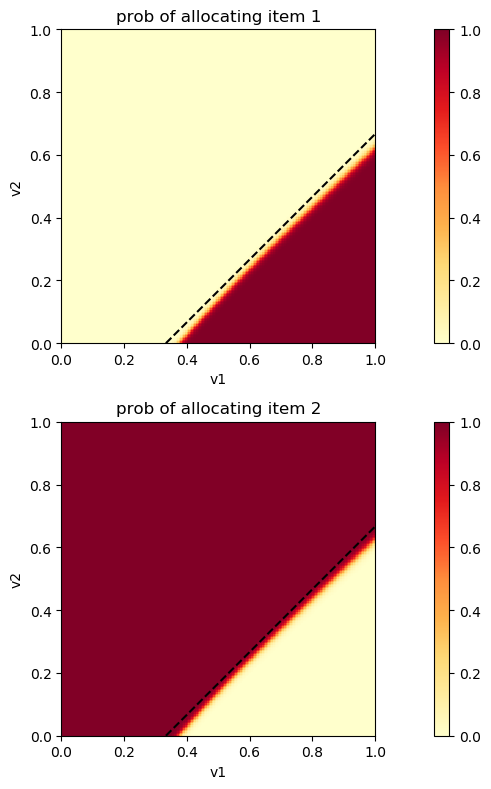

In [14]:
cpu_model.sinkhorn_rounds = 100
cpu_model.sinkhorn_epsilon = 1e-2
plot_12_model(cpu_model, 0.005, (0,1), (0,1))

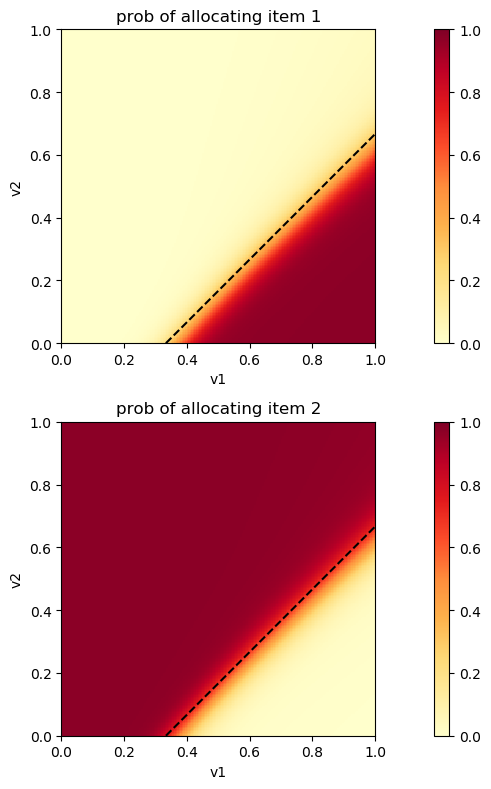

In [15]:
cpu_model.sinkhorn_rounds = 20
cpu_model.sinkhorn_epsilon = 5e-2
plot_12_model(cpu_model, 0.005, (0,1), (0,1))

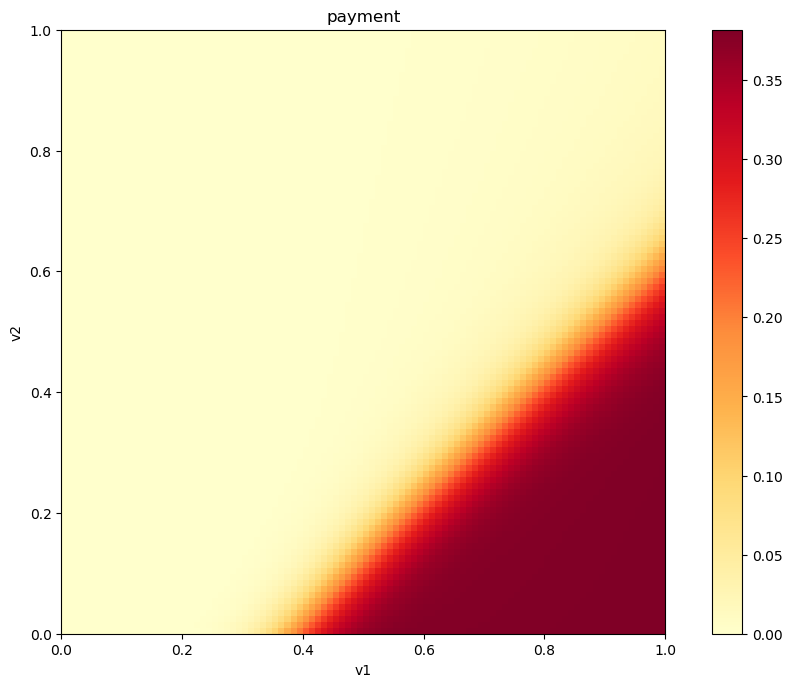

In [16]:
def plot_12_model_payments(model, grid_width=0.1, item1_range=(0, 1), item2_range=(0, 1), name="test"):
    item1_min, item1_max = item1_range
    item2_min, item2_max = item2_range
    xcoords = (item1_max - item1_min) * torch.arange(0, 1, grid_width).view(1, -1) + item1_min
    ycoords = (item2_max - item2_min) * torch.arange(0, 1, grid_width).view(-1, 1) + item2_min
    xlen = ycoords.shape[0]
    ylen = xcoords.shape[1]

    xcoords_tiled = xcoords.repeat(xlen, 1)
    ycoords_tiled = ycoords.repeat(1, ylen)

    combined = torch.stack((xcoords_tiled, ycoords_tiled), dim=2)

    output_allocs, output_payments = model(combined.view(-1, 1, 2))

    output_item1_payments = output_payments.view(xlen, ylen)
    f, (ax1) = plt.subplots(1, 1)
    im1 = ax1.imshow(output_item1_payments.cpu().detach().numpy(), origin='lower', cmap='YlOrRd',extent=[0,1,0,1])
    ax1.set_title('payment')
    ax1.set_xlabel('v1')
    ax1.set_ylabel('v2')
    f.colorbar(im1)
    f.show()
    
plot_12_model_payments(cpu_model, 0.01, (0,1), (0,1))

In [17]:
import pickle
to_pkl_lst = [mean_rgt, mean_pay, lagr_mults]
for i, fname in enumerate(['mean_rgt', 'mean_pay', 'lagr_mults']):
    with open(dir_name + fname, 'wb') as fp:
        pickle.dump(to_pkl_lst[i], fp)